# Question Answering

## Building a Review-Based QA System

### The Dataset

To build our QA system we’ll use the SubjQA dataset, which consists of more than 10,000 customer reviews in English about products and services in six domains: Trip‐Advisor, Restaurants, Movies, Books, Electronics, and Grocery.

In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/datasets/load.py:1486: FutureWarning: The repository for subjqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/subjqa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

We are going to focus on the Electronics domain

In [2]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

In [3]:
subjqa

DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})

In [4]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [5]:
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")
 
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


We can use the start index and length of the answer span to slice out the span of text in the review that corresponds to the answer.

In [6]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

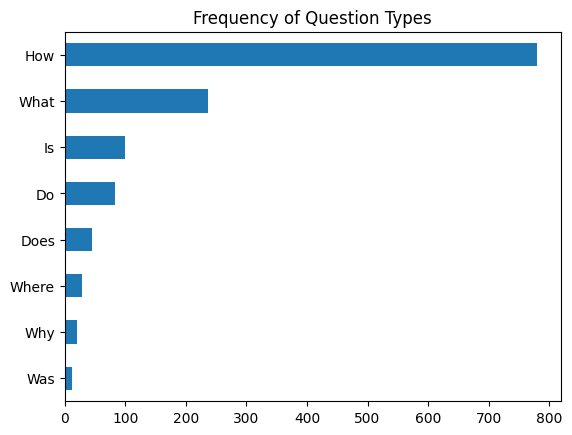

In [7]:
import matplotlib.pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]
for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]
pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [8]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)].sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


### Extracting Answers from Text

Since our training set is relatively small, with only 1,295 examples, a good strategy is to start with a language model that has already been fine-tuned on a large-scale QA dataset like SQuAD.

This is somewhat different from what we've done previously. In Chapter 2, we had to fine-tune the classification head because the number of classes was tied to the dataset at hand. For extractive QA, we can actually start with a fine-tuned model since the structure of the labels remains the same across datasets.

The most common way to extract answers from text is by framing the problem as a span classification task, where the start and end tokens of an answer span act as the labels that a model needs to predict.

As usual, the first thing we need is a tokenizer to encode our texts, so let’s take a look at how this works for QA tasks.

#### Tokenizing text for QA

In [9]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""

inputs = tokenizer(question, context, return_tensors="pt")

In [11]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [12]:
inputs["input_ids"][0]

tensor([  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
        23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
        25961,  2847,  5834,  2006,  5371,  2946,  1012,   102])

In [13]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


Now that our text is tokenized, we just need to instantiate the model with a QA head and run the inputs through the forward pass:

In [14]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)
with torch.no_grad():
    outputs = model(**inputs)
    
print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [15]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [16]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [17]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]

answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [18]:
# we can do all that by simply importing the model as a pipeline
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

2024-06-25 19:27:05.509228: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/transformers/pipelines/question_answer

[{'score': 0.2651623785495758, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082938253879547,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253461450338364,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

#### Dealing with long passages

the standard way to deal with the problem of having inputs larger than what the model can support is to apply a sliding window across the inputs, where each window contains a passage of tokens that fit in the model’s context.

we can set return_overflowing_tokens=True in the tokenizer to enable the sliding window. The size of the sliding window is controlled by the max_seq_length argument, and the size of the stride is controlled by doc_stride.

In [19]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], return_overflowing_tokens=True, max_length=100, stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [20]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [21]:
len(tokenized_example.input_ids)

2

In [22]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



### Using Haystack to build a QA Pipeline

To build our QA system, we’ll use the Haystack library developed by deepset, a German company focused on NLP. Haystack is based on the retriever-reader architecture, abstracts much of the complexity involved in building these systems, and integrates tightly with Transformers.

##### initializing a document store

In Haystack, there are various document stores to choose from and each one can be paired with a dedicated set of retrievers.

It won't be possible to continue this chapter because the security restrictions of my computer does not allow me to start elasticsearch.

In [23]:
# import os
# from subprocess import Popen, PIPE, STDOUT

In [24]:
# url = """https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-darwin-x86_64.tar.gz"""
# !wget -nc -q {url}
# !tar -xzf elasticsearch-7.9.2-darwin-x86_64.tar.gz

In [25]:
# import subprocess
# import os
# from time import sleep
# import requests

# # Define the path to the Elasticsearch executable
# elasticsearch_path = './elasticsearch-8.14.1/bin/elasticsearch'

# # Start Elasticsearch as a background process
# es_process = subprocess.Popen([elasticsearch_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# # Allow some time for Elasticsearch to start
# sleep(30)

# # Verify Elasticsearch is running
# try:
#     response = requests.get('http://localhost:9200')
#     if response.status_code == 200:
#         print("Elasticsearch is running")
#     else:
#         print("Failed to start Elasticsearch")
# except Exception as e:
#     print(f"Error connecting to Elasticsearch: {e}")

Assuming that our Elasticsearch server is up and running, the next thing to do is instantiate the document store:

In [27]:
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [ ]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"text": row["context"],
             "meta":{"item_id": row["title"], "question_id": row["id"],
                     "split": split}}
            for _,row in df.drop_duplicates(subset="context").iterrows()] 
    
    document_store.write_documents(docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")

##### initializing a retriever

In [ ]:
from haystack.retriever.sparse import ElasticsearchRetriever

# using the BM25 by default
es_retriever = ElasticsearchRetriever(document_store=document_store)

In [ ]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [ ]:
print(retrieved_docs[0])

In [ ]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False, max_seq_len=max_seq_length, doc_stride=doc_stride, return_no_answer=True)

In [ ]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

##### Putting it all together

In [ ]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

In [ ]:
n_answers = 3
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers, filters={"item_id": [item_id], "split":["train"]})
print(f"Question: {preds['query']} \n")

In [ ]:
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx]['answer']}")
    print(f"Review snippet: ...{preds['answers'][idx]['context']}...")
    print("\n\n")

## Improving Our QA Pipeline